# Librerías


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from arima import (
    arima_rolling_training_rolling_prediction,
    plot_arima,
)
from sklearn.metrics import root_mean_squared_error  # type: ignore
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from pmdarima import auto_arima

## Leemos la data


In [2]:
train_df = pd.read_parquet("../../../data/time_series/train_df.parquet").asfreq("D")
validation_df = pd.read_parquet(
    "../../../data/time_series/validation_df.parquet"
).asfreq("D")
test_df = pd.read_parquet("../../../data/time_series/test_df.parquet").asfreq("D")

In [3]:
train_and_validation_df = pd.concat([train_df, validation_df])
df = pd.concat([train_df, validation_df, test_df])

# AUTO ARIMA

Primero vamos a encontrar el modelo ARIMA óptimo para la serie de tiempo. Para esto vamos a utilizar la función auto_arima de la librería pmdarima.


In [4]:
auto_arima_model = auto_arima(
    train_and_validation_df["gap"],
    max_p=10,
    m=7,
    maxiter=500,
    seasonal=False,
    trace=True,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=False,
    out_of_sample_size=len(validation_df),
)

# Resumen del modelo
print(auto_arima_model.summary())

/Users/david/eafit/proyecto-integrador-semestre-2/.venv/lib/python3.11/site-packages/pmdarima/arima/_validation.py:62: UserWarning: m (7) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=99887.366, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=98498.736, Time=0.49 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=98240.929, Time=0.84 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=98237.459, Time=1.31 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=98150.693, Time=0.92 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=98132.244, Time=1.24 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=99452.685, Time=0.34 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=98285.215, Time=0.80 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=98243.466, Time=0.76 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=98178.027, Time=1.61 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=98135.247, Time=1.20 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=98978.445, Time=0.45 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=98196.285, Time=0.68 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=98099.441, Time=1.67 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=3.54 sec
 

In [5]:
arima_order = auto_arima_model.get_params().get("order")
print(f"AUTO ARIMA ARIMA order: {arima_order}")

AUTO SARIMA ARIMA order: (2, 1, 2)


# Predicciones


In [6]:
predictions = auto_arima_model.predict(len(test_df["gap"]))

## Grafica de resultados


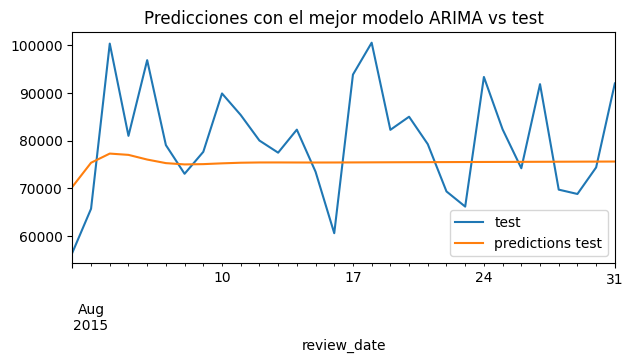

In [7]:
fig, ax = plt.subplots(figsize=(7, 3))
test_df["gap"].plot(ax=ax, label="test")
plt.plot(test_df["gap"].index, predictions, label="predictions test")
ax.set_title("Predicciones con el mejor modelo ARIMA vs test")
ax.legend()
plt.show()

In [8]:
rmse = root_mean_squared_error(test_df["gap"], predictions)
mape = mean_absolute_percentage_error(test_df["gap"], predictions)
mae = mean_absolute_error(test_df["gap"], predictions)

In [9]:
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")
print(f"MAE: {mae}")

RMSE: 11728.961704473593
MAPE: 0.11586690569381465
MAE: 9539.712456550158


# Best model with rolling training rolling prediction


In [10]:
(
    mape_arima_rolling,
    rmse_arima_rolling,
    [predictions_arima_rolling, values_arima_rolling],
) = arima_rolling_training_rolling_prediction(
    train_df=train_and_validation_df,
    test_df=test_df,
    arima_order=arima_order,
    column="gap",
)

/Users/david/eafit/proyecto-integrador-semestre-2/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/david/eafit/proyecto-integrador-semestre-2/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA Order: (2, 1, 2)
RMSE: 11511.422969469038
MAPE: 11.46%
MAE: 9209.294720598982


In [11]:
plot_arima(
    test_df,
    values_arima_rolling,
    predictions_arima_rolling,
    title="Valores reales vs predicciones del modelo ARIMA usando ROLLING TRAINING - ROLLING PREDICTIONS",
)